# Aim

In this project, we would like to train a Generative Adversarial Network (GAN) to simulate dynamic earth processes from data generated by GOSPL. To do so, we will first need to generate a lot of data that our GAN can learn from. In this notebook, we will use noise based methods to initiate many GOSPL simulations, which we will use as training data for our GAN. 

At this stage of the project, I keep the random data generation as simple as possible, so I can focus on testing out different GANs. This will serve as a proof of concept, and once I have a GAN that can faithfully learn from our simple data, we can then focus on generating more diverse GOSPL simulations.

# Running this Notebook

To run this notebook, I reccomend using [this docker environment for GOSPL](https://hub.docker.com/r/geodels/gospl). The main libraries needed here are GOSPL and Pyvista. You will not need GOSPL to run the next notebook where we will be requiring tensorflow instead.

# Noise

To randomly generate input data for GOSPL, we will need to generate random noise. We will be taking advantage of the pyvista perlin noise function as our base source of noise. Note that the *pv.perlin_noise* function is fairly new to pyvista and so we must use the latest version of pyvista to take advantage of it.

The perlin noise function always returns the exact same values if the input is the same, making it not random. To make it pseudo random, we will pass it a random phase offset.

In [1]:
import os
import h5py
import stripy
import meshplex
import numpy as np
import pyvista as pv
from PIL import Image
import matplotlib.pyplot as plt
from gospl.model import Model as sim
from gospl._fortran import definegtin
from scipy.interpolate import griddata

In [2]:
#Given a list of XYZ coordinates, we sample a noise value at each point
def samplePerlinNoise(XYZ, amplitude=1, frequency=4, offset=None):
    if offset == None: #Random offset if none other is specified
        offset = np.random.rand(3) * 100000
    freq = (frequency, frequency, frequency)
    noise = pv.perlin_noise(amplitude, freq, offset)
    return np.array([noise.EvaluateFunction(xyz) for xyz in XYZ])
    
#Create a plane, sample noise and apply noise to heights of points on plane
plane = pv.Plane(i_size=10, j_size=10, i_resolution=400, j_resolution=400)
noiseSamples = samplePerlinNoise(plane.points)
plane.points[:, 2] += noiseSamples * 0.1

#Plot the results
plotter = pv.PlotterITK()
plotter.add_mesh(plane, scalars=noiseSamples)
plotter.show()

Viewer(geometries=[{'vtkClass': 'vtkPolyData', 'points': {'vtkClass': 'vtkPoints', 'name': '_points', 'numberO…

Viewer(geometries=[{'vtkClass': 'vtkPolyData', 'points': {'vtkClass': 'vtkPoints', 'name': '_points', 'numberO…

The above noise function only has a single frequency within it, and therefore looks a bit too artificial. To make the noise look more natural, we will sum up multiple noise samples, each with their own frequency and amplitude. We refer to each noise sample as an octave of the final noise. Given a specified initial frequency, each octave will have a frequency of:

$$ f_{oct} = f_{init}  s_o ^ i$$

where $s_o$ is the octave step size and $i$ is the current number of the current octave. Each noise sample will have a decreasing amplitude based on the amplitude step size.

In [3]:
#Sample noise with multiple noise frequencies
def sampleNoise(XYZ, initialFrequency=1, octaves=8, octaveStepSize=1.4, amplitudeStepSize=2):
    noiseSum = np.zeros(XYZ.shape[0])
    for i in range(octaves):
        frequency =  initialFrequency * octaveStepSize ** i
        noiseSum += samplePerlinNoise(XYZ, frequency=frequency) / (amplitudeStepSize*(i+1))
    return noiseSum

#Create a plane, sample noise and apply noise to heights of points on plane
plane = pv.Plane(i_size=10, j_size=10, i_resolution=400, j_resolution=400)
noiseSamples = sampleNoise(plane.points)
plane.points[:, 2] += noiseSamples * 0.4

#Plot the results
plotter = pv.PlotterITK()
plotter.add_mesh(plane, scalars=noiseSamples)
plotter.show()

Viewer(geometries=[{'vtkClass': 'vtkPolyData', 'points': {'vtkClass': 'vtkPoints', 'name': '_points', 'numberO…

Viewer(geometries=[{'vtkClass': 'vtkPolyData', 'points': {'vtkClass': 'vtkPoints', 'name': '_points', 'numberO…

# Spheres

Although pyvista does have a built in function for creating spheres, it returns a UV sphere. Since GOSPL requires an Icosphere, we will generate one from the *stripy* library and convert it to a pyvista object instead. In the code bellow, we generate an Icosphere and convert it to a pyvista object. We then plot the Icosphere in blue, and a UV sphere in red for comparisons. Notice how the layout of vertices and edges are different.

Since we will be needing the cell array generated by stripy later on, we can store this array within the pyvista mesh object.

In [4]:
#Create a pyvista icosphere from stripy library (since pyvista doesn't have an Icosphere)
def createIcosphere(subdivisions=6, radius=6378137):
    icosphere = stripy.spherical_meshes.icosahedral_mesh( 
                    refinement_levels = subdivisions,
                    include_face_points = False)
    icosphereXYZ = icosphere._points * radius
    icoFaces = stripyCellsToPyvistaFaces(icosphere.simplices)
    icoMesh = pv.PolyData(icosphereXYZ, icoFaces)
    icoMesh['cells'] = icosphere.simplices
    return icoMesh

#Create an array for the pyvista faces based on stripy cells
def stripyCellsToPyvistaFaces(cells):
    faces = []
    for cell in cells:
        faces.append(3)
        faces.append(cell[0])
        faces.append(cell[1])
        faces.append(cell[2])
    return np.array(faces)

#Run function for creating Icosphere, and move sphere along x axis
icosphere = createIcosphere(subdivisions=4, radius=0.5)
icosphere.points[:, 0] += 0.55

#Create a UV-Sphere for comparisons
uvSphere = pv.Sphere(center=(-0.55, 0, 0))

#Plot the results
plotter = pv.PlotterITK()
plotter.add_mesh(uvSphere, color='r')
plotter.add_mesh(icosphere, color='b')
plotter.add_mesh(icosphere.extract_all_edges(), color='white', opacity=0.6)
plotter.add_mesh(uvSphere.extract_all_edges(), color='white', opacity=0.6)
plotter.show()

Viewer(geometries=[{'vtkClass': 'vtkPolyData', 'points': {'vtkClass': 'vtkPoints', 'name': '_points', 'numberO…

Viewer(geometries=[{'vtkClass': 'vtkPolyData', 'points': {'vtkClass': 'vtkPoints', 'name': '_points', 'numberO…

Since we are dealing with spheres, it is useful to be able to switch between the usual XYZ cartesian coordinate system, and the spherical polar coordinates as shown in the image bellow. This will allow us to move vertices along a radial direction, which we will need to apply a heightmap onto a sphere.

To convert from cartesian to polar coordinates, we use the following transformations:

$$r = \sqrt{x^2 + y^2 + z^2}$$
$$\theta = \tan^{-1} (\frac{y}{x})$$
$$\phi = \cos^{-1} (\frac{z}{r})$$

and to convert back to cartesian coordinates:

$$x = r \cos \theta \sin \phi$$
$$y = r \sin \theta \sin \phi$$
$$z = r \cos \phi$$

By default, these functions will take angles in the form of degrees, which is suitable for longitudinal and latitudinal coordinates, however they can also accept angles in the form of radians by setting *useLonLat* to False. Since there are slight other variations of spherical polar coordinates, we provide a link bellow to the article that we will be basing ours on: <br>
https://mathworld.wolfram.com/SphericalCoordinates.html 

<br>

<div>
<img src="Images/SphericalTransforms.jpg" width="900">
</div>

In [5]:
#Coordinate transformation from spherical polar to cartesian
def polarToCartesian(radius, theta, phi, useLonLat=True):
    if useLonLat == True:
        theta, phi = np.radians(theta+180.), np.radians(90. - phi)
    X = radius * np.cos(theta) * np.sin(phi)
    Y = radius * np.sin(theta) * np.sin(phi)
    Z = radius * np.cos(phi)
    
    print(type(X))
    #Return data either as a list of XYZ coordinates or as a single XYZ coordinate
    if (type(X) == np.ndarray):
        return np.stack((X, Y, Z), axis=1)
    else:
        return np.array([X, Y, Z])

#Coordinate transformation from cartesian to polar
def cartesianToPolarCoords(XYZ, useLonLat=True):
    X, Y, Z = XYZ[:, 0], XYZ[:, 1], XYZ[:, 2]
    R = (X**2 + Y**2 + Z**2)**0.5
    theta = np.arctan2(Y, X)
    phi = np.arccos(Z / R)

    #Return results either in spherical polar or leave it in radians
    if useLonLat == True:
        theta, phi = np.degrees(theta), np.degrees(phi)
        lon, lat = theta - 180, 90 - phi
        lon[lon < -180] = lon[lon < -180] + 360
        return R, lon, lat
    else:
        return R, theta, phi

Now that we have defined our spherical polar coordinate transformations, we can use those to move vertices up or down along the radial direction of a sphere. For demonstrational purposes, we generate an Icosphere and sample noise from its vertices. We then use the coordinate transformations to set the radius of the sphere by some amount based on the sampled noise.

By playing around with the parameters, we can get different results. For now, our noisy sphere looks like a meteorite, but by decreasing the noise amplitude we can make it a bit more earth like.

In [6]:
noiseAmplitude = 10000
earthRadius = 6378000

#Create an Icosphere and sample noise from its vertices to create a new radius.
icosphere = createIcosphere(subdivisions=6, radius=earthRadius)
noiseMap = sampleNoise(icosphere.points, initialFrequency=0.000001, octaves=8, octaveStepSize=1.5, amplitudeStepSize=2.4)
noisyRadius =  earthRadius + noiseMap * noiseAmplitude * 30

#Apply the noise radius to our sphere
r, lon, lat = cartesianToPolarCoords(np.array(icosphere.points))
noisySphereXYZ = polarToCartesian(noisyRadius, lon, lat)
noisySphere = pv.PolyData(noisySphereXYZ, icosphere.faces)

#Plot the results
plotter = pv.PlotterITK()
plotter.add_mesh(noisySphere, scalars=noiseMap)
plotter.show()

<class 'numpy.ndarray'>


Viewer(geometries=[{'vtkClass': 'vtkPolyData', 'points': {'vtkClass': 'vtkPoints', 'name': '_points', 'numberO…

Viewer(geometries=[{'vtkClass': 'vtkPolyData', 'points': {'vtkClass': 'vtkPoints', 'name': '_points', 'numberO…

In theory, although the above noise map does not look much like an earth like plannet, it is sufficient for randomly generating input elevation and uplift maps for GOSPL. After running multiple GOSPL simulation to get some training data, we can train our GAN, hopefully it learns the desired underlying geological phenomina and generalises well enough to be applied on more earth like inputs.

In theory, the more diverse our data is, the more our GAN will generalize, so using multiple methods for creating input data should be beneficial. Also, there is no point for me to improve the input data if I later find out that we did not need to do so anyways. I don't actually know what to expect, but using this as input data will allow me to experiment with the GAN structure, and we can improve the input data afterwards if the GAN does not generalize well.

# Gospl

Gospl needs a zipped numpy array file *.NPZ* to specify the intial elevations of the planet. It must contain the following arrays:

- **v**: **Vertices** - Of the original flat sphere
- **c**: **Cells** - Details about the mesh connectivity
- **n**: **Nearest Neighbours** - Details of each vertices neighbours
- **z**: **Elevations** - The height at each vertex

In [7]:
#Create list of neighbour ids, based on bfModel notebook tutorial
def getNeighbourIds(icoXYZ, icoCells):
    Gmesh = meshplex.MeshTri(icoXYZ, icoCells)
    s = Gmesh.idx_hierarchy.shape
    a = np.sort(Gmesh.idx_hierarchy.reshape(s[0], -1).T)
    Gmesh.edges = {'points': np.unique(a, axis=0)}
    ngbNbs, ngbID = definegtin(len(icoXYZ), Gmesh.cells('points'), Gmesh.edges['points'])
    ngbIDs = ngbID[:,:8].astype(int)
    return ngbIDs

#Create an array of elevations
def addElevationsToSphere(icosphere, 
                           octaves=8, 
                           octaveStepSize=1.5, 
                           amplitudeStepSize=2.4,
                           initialFrequency=0.000001):
    noiseMap = sampleNoise(icosphere.points, 
                           octaves=octaves, 
                           octaveStepSize=octaveStepSize, 
                           amplitudeStepSize=amplitudeStepSize,
                           initialFrequency=initialFrequency)
    icosphere['elevations'] = noiseMap * noiseAmplitude + noiseAmplitude * 0.3
    return icosphere
    
def createInitialTopographyNPData(
                                octaves=8,
                                subdivisions=6,
                                octaveStepSize=1.5, 
                                earthRadius=6378000,
                                noiseAmplitude=10000,
                                amplitudeStepSize=2.4,
                                initialFrequency=0.000001,
                                fileName = './GeneratedData/initLandscape.npz'):
    
    #Create an Icosphere and get it's vertices and cells
    icosphere = createIcosphere(subdivisions=subdivisions, radius=earthRadius)
    vertices = icosphere.points

    #Get the cell array that we attached to the icosphere mesh object earlier on
    cells = icosphere['cells']
    
    icosphere = addElevationsToSphere(icosphere)
    elevations = icosphere['elevations']

    #Create a list of neighbour ids
    neighbs = getNeighbourIds(vertices, cells)
    
    #Save the file
    np.savez_compressed(fileName, v=vertices, c=cells, n=neighbs.astype(int), z=elevations)
    return icosphere
    
icosphere = createInitialTopographyNPData()

#Plot the results
plotter = pv.PlotterITK()
plotter.add_mesh(icosphere, scalars='elevations')
plotter.show()

Viewer(geometries=[{'vtkClass': 'vtkPolyData', 'points': {'vtkClass': 'vtkPoints', 'name': '_points', 'numberO…

Viewer(geometries=[{'vtkClass': 'vtkPolyData', 'points': {'vtkClass': 'vtkPoints', 'name': '_points', 'numberO…

In [8]:
#Create list of neighbour ids, based on bfModel notebook tutorial
def getNeighbourIds(icoXYZ, icoCells):
    Gmesh = meshplex.MeshTri(icoXYZ, icoCells)
    s = Gmesh.idx_hierarchy.shape
    a = np.sort(Gmesh.idx_hierarchy.reshape(s[0], -1).T)
    Gmesh.edges = {'points': np.unique(a, axis=0)}
    ngbNbs, ngbID = definegtin(len(icoXYZ), Gmesh.cells('points'), Gmesh.edges['points'])
    ngbIDs = ngbID[:,:8].astype(int)
    return ngbIDs

#Create an Icosphere and get it's vertices and cells
icosphere = createIcosphere(subdivisions=6, radius=earthRadius)
vertices = icosphere.points

#Get the cell array that we attached to the icosphere mesh object earlier on
cells = icosphere['cells']

icosphere = addElevationsToSphere(icosphere)
elevations = icosphere['elevations']

#Create a list of neighbour ids
neighbs = getNeighbourIds(vertices, cells)

# Generating Lots of Training Data

In the code bellow, the function *runTrial()* will run a single gospl trial with the randomly generated input data above. The trials will be saved in a directory named *TrainingData*, and each trial will have their own *Tial{}* folder with some trial number. By running the *runTrial()* function multiple times, we will generate training data for our GAN.

In [9]:
#Create one set of training data by running gospl
def runTrial(dataDir = './TrainingData',
            trialDirFormat = '{}/Trial{}',
            npzDirFormat = '{}/NPZFiles',
            initElevNPZformat = '{}/initElevations.npz',
            ymlFileToCopy = 'NoiseSphereInput.yml'):
    
    #Make directory of training data if it does not already exist
    if not os.path.isdir(dataDir):
        os.mkdir(dataDir)

    #Create a new subdirectories for each trial
    trialNumber = 0
    trialDir = trialDirFormat.format(dataDir, trialNumber)
    while os.path.isdir(trialDir):
        trialNumber += 1
        trialDir = trialDirFormat.format(dataDir, trialNumber)
    npzDir = npzDirFormat.format(trialDir)
    initElevNPZ = initElevNPZformat.format(npzDir)
    os.mkdir(trialDir)
    os.mkdir(npzDir)
    
    #Create npz file if initial elevation
    icosphere = createInitialTopographyNPData(fileName=initElevNPZ)
    
    #Read the YML file to copy
    newYMLfileDir = trialDir + '/' + ymlFileToCopy
    with open(ymlFileToCopy, 'r') as ymlFile:
        ymlContent = ymlFile.read()
        
    #Fill in the missing blanks in the YML file and save it into the trial directory
    ymlContent = ymlContent.format(trialDir, trialDir)
    with open(newYMLfileDir, 'w') as newYMLfile:
        newYMLfile.write(ymlContent)
    
    #Run simulation
    mod = sim(newYMLfileDir, False, False)
    mod.runProcesses()
    mod.destroy()

Running the code bellow will generate training data until the user interupts. Since we will be needing lots of training data, we let this cell run overnight, and interupt it in the morning.

Some data is provided in the Github. The provided data may be sufficient to run and debug code within this notebook, but it is not sufficient to effectively train any sort of machine learning network. On my local computer, I have run 360 different trials with the code bellow, which is about 40 Gb of data, too large to be included in the github.

Note that on my computer, a single trial using the cell bellow takes about 112 seconds to run, thats 11.2 seconds per iteration to run.

In [10]:
while False:
    runTrial()

# Reading and Visualizing Training Data

Here we provide some functions for reading and visualizing the generated trainind data.

In [11]:
import h5py

#The Gospl file contains simulation output data at particular iterations during the simulation
def readGosplFile(fileDir):
    gosplDict = {}
    with h5py.File(fileDir, "r") as f:
        for key in f.keys():
            gosplDict[key] = np.array(f[key])
    return gosplDict

#Create a sphere from the gospl output topography files
def createSphereMesh(topoXYZ):
    r, lon, lat = cartesianToPolarCoords(topoXYZ)
    lonLatFlat = np.stack((lon, lat, np.zeros(lon.shape))).T
    faces = pv.PolyData(lonLatFlat).delaunay_2d().faces
    return pv.PolyData(topoXYZ, faces)

#Exagerated mesh for plotting
def createExageratedMesh(sphereMesh, keys, iteration=10, trialNumber=0):
    dataFile = trialDataDirFormat.format(trialNumber) + 'gospl.{}.p0.h5'.format(iteration)
    data = readGosplFile(dataFile)
    r, lon, lat = cartesianToPolarCoords(sphereMesh.points)
    exegeratedRadius = earthRadius + 60 * data['elev']
    sphereMesh.points =  polarToCartesian(exegeratedRadius[:, 0], lon, lat).T
    for key in keys:
        sphereMesh[key] = data[key]
    return sphereMesh
    
    
trialNumber = 0
trialDataDirFormat = './TrainingData/Trial{}/NoiseSphere/h5/'
gosplKeys = ['elev', 'erodep', 'fillFA', 'flowAcc', 'rain', 'sedLoad']

#Read topology file
topologyFile = trialDataDirFormat.format(trialNumber) + 'topology.p0.h5'
topoDict = readGosplFile(topologyFile)
sphereXYZ = topoDict['coords']
sphereMesh = createSphereMesh(sphereXYZ)

#Read simulation data at iteration
iteration = 0
dataFile = trialDataDirFormat.format(trialNumber) + 'gospl.{}.p0.h5'.format(iteration)
dataDict = readGosplFile(dataFile)

#Create a mesh of our randomly generated planet and plot results
plotter = pv.PlotterITK()
planetMesh = createExageratedMesh(sphereMesh, gosplKeys, iteration=iteration, trialNumber=trialNumber)
plotter.add_mesh(planetMesh, scalars=dataDict['elev'])
plotter.show()

<class 'pyvista.core.pyvista_ndarray.pyvista_ndarray'>


Viewer(geometries=[{'vtkClass': 'vtkPolyData', 'points': {'vtkClass': 'vtkPoints', 'name': '_points', 'numberO…

Viewer(geometries=[{'vtkClass': 'vtkPolyData', 'points': {'vtkClass': 'vtkPoints', 'name': '_points', 'numberO…

The code bellow generates animations of our GOSPL simulation. Again, the resulting data is not too exciting, but it sufficient for prototyping different tensorflow neural networks.

In [15]:
def animateGosplResults(trialNumber, 
                        iterations=10, 
                        framesPerIteration=8, 
                        scalarToPlot='elev',
                       animationDir='ErosionAnimation.mp4'):
    
    topologyFile = trialDataDirFormat.format(trialNumber) + 'topology.p0.h5'
    topoDict = readGosplFile(topologyFile)
    sphereXYZ = topoDict['coords']
    sphereMesh = createSphereMesh(sphereXYZ)

    #Create initial planet mesh
    dataFile = trialDataDirFormat.format(trialNumber) + 'gospl.{}.p0.h5'.format(0)
    dataDict = readGosplFile(dataFile)
    planetMesh = createExageratedMesh(sphereMesh, gosplKeys, iteration=0, trialNumber=trialNumber)

    #Initiate the plotter for animation
    plotter = pv.Plotter()
    plannetActor = plotter.add_mesh(planetMesh, scalars=dataDict[scalarToPlot])
    plotter.camera.zoom(1.4)
    plotter.open_movie(animationDir)
    for i in range(framesPerIteration):
        plotter.write_frame()

    #Loop through all iteration data files and draw animation frames
    for i in range(iterations):
        dataFile = trialDataDirFormat.format(trialNumber) + 'gospl.{}.p0.h5'.format(i+1)
        dataDict = readGosplFile(dataFile)
        planetMesh = createExageratedMesh(sphereMesh, gosplKeys, iteration=i+1, trialNumber=trialNumber)
        newScalars = dataDict[scalarToPlot]

        #Draw animation frames
        plotter.remove_actor(plannetActor)
        plannetActor = plotter.add_mesh(planetMesh, scalars=dataDict[scalarToPlot])
        for i in range(framesPerIteration):
            plotter.write_frame()
    plotter.close()

animateGosplResults(1)

<class 'pyvista.core.pyvista_ndarray.pyvista_ndarray'>
<class 'pyvista.core.pyvista_ndarray.pyvista_ndarray'>
<class 'pyvista.core.pyvista_ndarray.pyvista_ndarray'>
<class 'pyvista.core.pyvista_ndarray.pyvista_ndarray'>
<class 'pyvista.core.pyvista_ndarray.pyvista_ndarray'>
<class 'pyvista.core.pyvista_ndarray.pyvista_ndarray'>
<class 'pyvista.core.pyvista_ndarray.pyvista_ndarray'>
<class 'pyvista.core.pyvista_ndarray.pyvista_ndarray'>
<class 'pyvista.core.pyvista_ndarray.pyvista_ndarray'>
<class 'pyvista.core.pyvista_ndarray.pyvista_ndarray'>
<class 'pyvista.core.pyvista_ndarray.pyvista_ndarray'>


# Preprocess Data for Tensorflow

Many machine learning libraries such as tensorflow have plenty of tools and algorithms built in to deal with image type data, so to keep things simple, we would like to convert our data set into an image representation. This will allow us to use convolutional layers in our neural network (NN), which tends to perform really well in images.

Note that many of the novel NN based physics simulators use graph based methods, and generalize the convolutional layer into a general graph rather than restricting it on a 2D image format. Although this is the approach we might want to use in the future, these methods have only been around for a few years, and the tools for graph based methods are not as well established as compared to the usual image convolution layers. So to keep things simple for now, we will represent our data as images.

To convert our data into image representations, we will interpolate our data into UV sphere. The lon/lat coordinates of vertices of a UV sphere can then be represented as the XY location that they fall into in the image, and parameters such as elevation and erosion deposition can be represented using the RGB channels of the image.

The code bellow demonstrates how we can convert a UV sphere into a flat grid. Note that we will need to remove the vertices on the north/south poles to make this work. This grid can then be represented as an image.

In [16]:
#Create UV sphere
uvSphere = pv.Sphere()
r, theta, phi = cartesianToPolarCoords(uvSphere.points)
theta[theta<=0] += 360

#Convert to flat point cloud
zeros = np.zeros(theta.shape)
XYZ = np.array([zeros, theta, phi]).T

#Remove first two coordinates corresponding to north and south pole
XYZ = XYZ[2:, :]
lonLatPointCloud = pv.PolyData(XYZ)

#Color to plot our points with
colors = np.arange(XYZ.shape[0])

#Plot results
plotter = pv.PlotterITK()
plotter.add_mesh(lonLatPointCloud, scalars=colors)
plotter.background_color  = 'grey'
plotter.show()

Viewer(background=(0.5019607843137255, 0.5019607843137255, 0.5019607843137255), geometries=[{'vtkClass': 'vtkP…

Viewer(background=(0.5019607843137255, 0.5019607843137255, 0.5019607843137255), geometries=[{'vtkClass': 'vtkP…

We now need to interpolate our data onto a UV sphere. To do so, we will need the lon/lat coordinates of the Icosphere to interpolate from, the lon/lat coordinates of the UV sphere to interpolate onto, and the data to interpolate. We can then use the griddata interpolator form the scipy library.

Note that since images have 3 color channels (RGB), we can use 3 scalar values produced by Gospl in the image. This will give more data for our NN to work with. In the code bellow, we interpolate elevation, erosion deposition and flow accumulation.

In [19]:
#Create lon/lat from gospl's icosphere to interpolate from
def getIcoLonLat(trialNumber=0):
    topologyFile = trialDataDirFormat.format(trialNumber) + 'topology.p0.h5'
    topoDict = readGosplFile(topologyFile)
    icoSphereXYZ = topoDict['coords']
    icoSphereMesh = createSphereMesh(icoSphereXYZ)
    _, icoLon, icoLat = cartesianToPolarCoords(icoSphereXYZ)
    icoLon[icoLon<=0] += 360
    return np.array([icoLon, icoLat]).T

#Create lon/lat to interpolate onto
def getUVLonLat(resolution=[512, 258]):
    uvSphere = pv.Sphere(theta_resolution=resolution[0], phi_resolution=resolution[1])
    _, uvLon, uvLat = cartesianToPolarCoords(uvSphere.points)
    uvLon[uvLon<=0] += 360
    return np.array([uvLon, uvLat]).T

#Use griddata interpolation to get scalars of the UV sphere
def getInterpolatedData(trialNumber, iteration, icoLonLat, uvLonLat,
                        scalarsToInterpolate=['elev', 'erodep', 'flowAcc']):
    
    #Get data to interpolate
    dataFile = trialDataDirFormat.format(trialNumber) + 'gospl.{}.p0.h5'.format(iteration)
    dataDict = readGosplFile(dataFile)
    interpolatedScalars = []
    
    #Loop through all scalars to interpolate
    for scalar in scalarsToInterpolate:
        newScalar = griddata(icoLonLat, dataDict[scalar], uvLonLat)
        whereNAN = np.argwhere(np.isnan(newScalar))
        newScalar[whereNAN] = griddata(icoLonLat, dataDict[scalar], uvLonLat[whereNAN], method='nearest')
        interpolatedScalars.append(newScalar)
    return np.array(interpolatedScalars).T[0]

trialNumber = 1
iteration = 10

#Get interpolated data for the UV sphere
uvLonLat = getUVLonLat()
icoLonLat = getIcoLonLat()
interpolatedData = getInterpolatedData(trialNumber, iteration, icoLonLat, uvLonLat)

#Plot results
plotter = pv.PlotterITK()
uvSphere = pv.Sphere(theta_resolution=512, phi_resolution=258)
plotter.add_mesh(uvSphere, scalars=interpolatedData[:, 0])
plotter.show()

Viewer(geometries=[{'vtkClass': 'vtkPolyData', 'points': {'vtkClass': 'vtkPoints', 'name': '_points', 'numberO…

Viewer(geometries=[{'vtkClass': 'vtkPolyData', 'points': {'vtkClass': 'vtkPoints', 'name': '_points', 'numberO…

Now that we have the data interpolated onto a UV sphere, we can represent it by an image. First we reshape the data array into an image shape, and then bring all values to a range from 0 to 255 as required for 8 bit pixels. We also raise the flow accumulation variable by the power of 0.125, to make it's distribution more linear and therefore more visible.

Note: I've recently made the relization that I could probably save the data as NPZ files and avoid loss of fidelity due to saving as PNG and the 8 Bit restriction. The data still needs to be represented in a flat 2D image like grid of values though, but I'm not restricted to 3 RGB channels either. I will fix this once the GAN prototype is working.

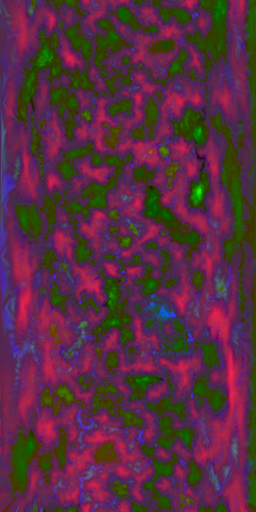

In [20]:
#The interpolated data is save in the RGB channels of the image
#We bring data into range from 0 to 255, as required for images
def createImage(rgb):
    RGB = np.copy(rgb)
    RGB = RGB[2:].reshape(512, 256, 3)
    RGB[:, :, 2] = RGB[:, :, 2]**0.125
    RGB -= np.min(interpolatedData, axis=0)
    RGB[:, :, 0] /= np.max(RGB[:, :, 0])
    RGB[:, :, 2] /= np.max(RGB[:, :, 2])
    if np.max(RGB[:, :, 1]) != 0:
        RGB[:, :, 1] /= np.max(RGB[:, :, 1])
    RGB *= 255
    return Image.fromarray(RGB.astype(np.uint8))

trialNumber = 1
iteration = 10

#Get data to be represented by images
uvLonLat = getUVLonLat()
icoLonLat = getIcoLonLat()
interpolatedData = getInterpolatedData(trialNumber, iteration, icoLonLat, uvLonLat)

#Display or save image
img = createImage(interpolatedData)
img.save('testImage.png')
img.show()

We probably also want to make sure we can read images back into a spherical mesh format.

In [21]:
earthRadius = 6378000
rangeMax = np.array([9.21434829e+03, 5.20667833e+03, 3.23146528e+14])
rangeMin = np.array([-9.62599721e+02, -1.49130044e+03,  1.00000000e+00])

#Read image for heights data
image = Image.open("testImage.png")
dataArray = np.array(image)
heights = dataArray[:, :,0]
heights = heights * (rangeMax[0] - rangeMin[0]) / 255 + rangeMin[0]

#Insert back the north and south pole, for now we just let it be zero, but we can interpolate to get a better value
heights = np.insert(heights, 0, 0)
heights = np.insert(heights, 0, 0)

#Apply the noise radius to our sphere
uvSphere = pv.Sphere(radius=earthRadius, theta_resolution=512, phi_resolution=258)
r, lon, lat = cartesianToPolarCoords(np.array(uvSphere.points))
noisySphereXYZ = polarToCartesian(heights * 60 + earthRadius, lon, lat)
noisySphere = pv.PolyData(noisySphereXYZ, uvSphere.faces)

#Plot results
plotter = pv.PlotterITK()
plotter.add_mesh(noisySphere, scalars=heights)
plotter.show()

<class 'numpy.ndarray'>


Viewer(geometries=[{'vtkClass': 'vtkPolyData', 'points': {'vtkClass': 'vtkPoints', 'name': '_points', 'numberO…

Viewer(geometries=[{'vtkClass': 'vtkPolyData', 'points': {'vtkClass': 'vtkPoints', 'name': '_points', 'numberO…

Now that we have a way of representing our data as images, we wan't to convert all our data files into images for tensorflow. For each feature (input data), we want the target (output of NN) to be the next iteration of the GOSPL simulation. So each iteration will be an feature with the next iteration as the target data.

In machine learning literature, a feature is the input of a model, and the target is the output of a model.

In [25]:
trialNumber = 25
iteration = 10

#Get data to be represented by images
uvLonLat = getUVLonLat()
icoLonLat = getIcoLonLat()

#Loop through all images and save feature/target image pairs
count = 0
if False:
    for trial in range(2):
        for i in range(iteration):
            featureData = getInterpolatedData(trial, i, icoLonLat, uvLonLat)
            featureImage = createImage(featureData)
            featureImage.save('./ImageTrainingData/Features/feature{}.png'.format(count))

            targetData = getInterpolatedData(trial, i+1, icoLonLat, uvLonLat)
            targetImage = createImage(targetData)
            targetImage.save('./ImageTrainingData/Targets/target{}.png'.format(count))
            count += 1

# Next Notebook

We have succesfully used GOSPL to generate training data for our neural network. In the next notebook, we will explore various tensorflow models (GAN) and test out which ones perform the best.

To run the next notebook, make sure your python environment has access to tensorflow.